In [1]:
%load_ext autoreload
%autoreload 2


In [5]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib  as mpl

from mpl_toolkits.axes_grid1 import make_axes_locatable
from argparse import Namespace as NS
from os.path import join
import yaml
import torch
from torch import FloatTensor as FT
from syngan.models import OjaNet, OjaRule
from syngan.post_hoc_analysis import (load_network_from_checkpoint as load,
                                      make_new_data,
                                      generate_quiver, insets, rule_wrapper,
                                      plot_2Dheatmap)
from scipy.optimize import root
from matplotlib.cbook import get_sample_data


## Load fits and make data

In [6]:
# Load test data
path_to_data = join("..", "..", "data", "oja_net_small")
test_data = np.load(join(path_to_data, "extra_test_data.npz"))

with open(join(path_to_data, "config.yaml"), "r") as f:
    sconf = NS(**yaml.full_load(f))

X, Y, PCs, weights = test_data["presyn_act"], test_data["postsyn_act"],\
test_data["presyn_pcs"], test_data["weights"]

gt_net = OjaNet(OjaRule(sconf.n_presyn_neur, sconf.n_postsyn_neur),
                sconf.update_rate,
                sconf.n_presyn_neur,
                sconf.n_postsyn_neur,
                sconf.timesteps,
                noise_amplitude=0.)


In [7]:
# For figure 2: Load Loc MLP
path_to_loc_mlp = "../../runs/oja_net_small/<>"
loc_mlp_generator = load(path_to_loc_mlp,
                      "oja_net_small",
                      path_to_sim_conf="../../data/oja_net_small/",
                      path_to_fit_conf="../tasks/oja_net_small/")


In [8]:
# Make data for plots
generators = {"gt": gt_net,
              "loc_mlp": loc_mlp_generator}

# Make new data
test_wts = {}
test_outputs = {}
test_score = {}

torch.manual_seed(786)
random_wts = 1e-1 * torch.abs(torch.randn(len(X), 1, 3, 1))
for k, network in generators.items():
    wt, y, score = make_new_data(net="OjaNet",
                                 rule=network.update_rule,
                                 presyn_act=X,
                                 wt_init_seed=786,
                                 init_weights=random_wts,
                                 return_score=True,
                                 score_funcn="pc_norm",
                                 PCs=PCs)
    test_wts[k] = wt
    test_outputs[k] = y
    test_score[k] = score


## Set figure properties

In [9]:
labels = {"gt": "Oja's Rule",
          "loc_mlp": "Local MLP"}
colors = {"gt": "k",
          "loc_mlp": "tab:blue"}
linewidths = {"gt": 4,
              "loc_mlp": 4}


# Pick random set of datasets for plotting
panel_test_dataset=69
timebins = [9, 49, 199]
keys = ["gt", "loc_mlp"]


def get_roots():
    x = 0.5
    roots = {"gt": {"y": [-.5, 0., 0.5],
                    "w": [-1, 0., 1],
                    "init_w": [-1, 1],
                    },
             "loc_mlp": {"y": [-.25],
                         "init_w": [-.5],
                         "w": []}
            }

    # for ran, rand in zip([np.linspace(-.59, -.49, 10)], [-0.78530336]):
    for key in [k for k in roots.keys() if k!="gt"]:
        for yy, rand in zip(roots[key]["y"], roots[key]["init_w"]):
            rootfinder = root(rule_wrapper(generators[key].update_rule), rand, args=(x, yy),
                              method='hybr')#, jac=jac_rule(loc_mlp))
            roots[key]["w"].append(rootfinder.x)
    return roots


## Make figure

/home/poornima/Documents/synapse_gan/synapsegan/syngan/post_hoc_analysis/visualize.py:23: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  w = torch.FloatTensor([w]).reshape(1, 1, 1).repeat(1, 3, 1)


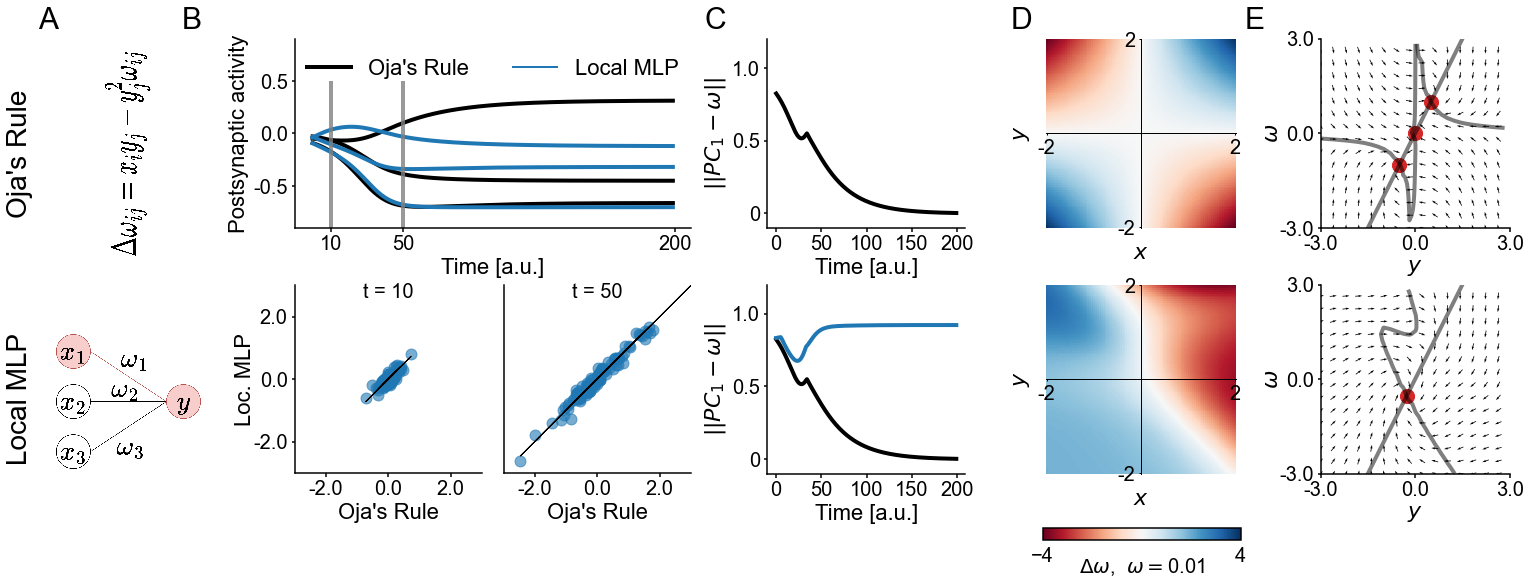

In [10]:
with mpl.rc_context(fname="./matplotlibrc"):
    fig = plt.figure(figsize=(25, 8))
    fig.patch.set_facecolor('white')
    fig.subplots_adjust(wspace=.35, hspace=.3)
    fig.tight_layout()

    gs = plt.GridSpec(2, 5, width_ratios=(1, 4, 2., 2, 2), height_ratios=(1., 1.))

    # Panel A
    cartoon_prefix = "../../cartoon_%s.png"
    for i, key in enumerate(keys):
        ax = plt.subplot(gs[i*5])
        if i == 0:
            im_ax = fig.add_axes([0.1, 0.5, .08, .36])
            im = plt.imread("../../oja_rule.png")
            im_ax.imshow(im, aspect='auto')
            im_ax.axis('off')
        else:
            im_ax = fig.add_axes([0.08, 0.1, .1, .3])
            im = plt.imread(get_sample_data(cartoon_prefix % key))
            im_ax.imshow(im)
            im_ax.axis('off')
        ax.axis('off')

    # Panel B
    for i, (key, pn) in enumerate(zip(keys, [panel_test_dataset]*2)):
        ax = plt.subplot(gs[i*5 + 1])
        if i == 0:
            ax.set_xlabel("Time [a.u.]", fontsize=22)
            ax.set_ylabel("Postsynaptic activity", fontsize=22)
            ax.set_xticks([t+1 for t in timebins])

            ax.set_ylim(-.9, .9)
            ax.set_yticks([-.5, 0., .5])
            ax.set_xticklabels(labels=[t+1 for t in timebins])
            ax.set_yticklabels(labels=[-.5, 0., .5])

            ax.plot(test_outputs["gt"][panel_test_dataset, [30, 3, 65]].squeeze().T,
                    lw=linewidths["gt"],
                    color=colors["gt"])
            ax.plot(test_outputs["loc_mlp"][panel_test_dataset, [30, 3, 65]].squeeze().T,
                    lw=linewidths["loc_mlp"],
                    color=colors["loc_mlp"])
            ax.vlines([t+1 for t in timebins[:-1]],
                      ymin=-1., ymax=.5, color="grey", lw=4, alpha=.8)

            ax.plot([], [], color=colors["gt"], label=labels["gt"], lw=4)
            ax.plot([], [], color=colors["loc_mlp"], label=labels["loc_mlp"], lw=2)
            ax.legend(frameon=False, fontsize=22, loc="upper center", ncol=2)
        else:
            ax.axis('off')
            for j, (t, loc) in enumerate(zip(timebins[:-1], ["left", "right"])):
                div = make_axes_locatable(ax)
                ax = div.append_axes(loc, size="100%", pad=.3)
                insets(ax, t, key, pn, colors, labels, test_outputs, ylabel="Loc. MLP", fontsize=20,
                       labelsize=22)


    # Panel C
    for i, (key, pn) in enumerate(zip(keys, [panel_test_dataset]*2)):
        ax = plt.subplot(gs[i*5 + 2])
        ax.set_xlabel("Time [a.u.]", fontsize=22)
        ax.set_ylabel(r"$||PC_1 - \omega||$", fontsize=22)
        ax.set_xticks([0, 50, 100, 150, 200])
        ax.set_ylim(-.1, 1.2)
        ax.set_yticks([0, .5, 1.])
        ax.set_xticklabels(labels=[0, 50, 100, 150, 200])
        ax.set_yticklabels(labels=[0, .5, 1.])

        lab_gt = labels["gt"] if i==0 else ""
        ax.plot(test_score["gt"][pn].T,
             color=colors["gt"],
             lw=linewidths["gt"],
                label=lab_gt,
             alpha=1.)
        if i > 0:
            ax.plot(test_score[key][pn].T,
                     color=colors[key],
                     lw=linewidths[key],
                     alpha=1.,
                     label=labels[key])



    # Panel D
    cax = fig.add_axes((.638, .01, .11, .02))

    for i, (key, colax) in enumerate(zip(keys, [None, cax])):
        ax = plt.subplot(gs[i*5 + 3])
        plot_2Dheatmap(rule_wrapper(generators[key].update_rule),
                       ax,
                       0.01,
                       cax=colax,
                       x_range = [-2.0,2.0],
                       y_range = [-2.0,2.0],
                       n_points = [100,100],
                       fontsize=20,
                       labelpad=85,
                       labelsize=22)


    # Panel E
    x = 0.5
    for i, (key, lim) in enumerate(zip(keys, [[-3, 3], [-3, 3]])):
        ax = plt.subplot(gs[i*5 + 4])
        roots = get_roots()
        w_range = np.linspace(lim[0], lim[1], 150)
        y_range = np.linspace(lim[0], lim[1], 150)

        Y, W, DY, DW = generate_quiver(rule_wrapper(generators[key].update_rule),
                                       w_range=w_range, y_range=y_range)
        ax.quiver(Y[::2, ::2], W[::2, ::2], DY[::2, ::2], DW[::2, ::2], pivot='mid')
        ax.set_xlim(lim[0], lim[1])
        ax.set_ylim(lim[0], lim[1])
        ax.set_aspect(1)
        ax.set_xticks(np.linspace(lim[0], lim[1], 3))
        ax.set_xticklabels(np.linspace(lim[0], lim[1], 3))
        ax.set_yticks(np.linspace(lim[0], lim[1], 3))
        ax.set_yticklabels(np.linspace(lim[0], lim[1], 3))
        ax.set_xlabel(r"$y$", fontsize=22)
        ax.set_ylabel(r"$\omega$", fontsize=22, labelpad=-2.5)


        y_fp, w_fp = roots[key]["y"], roots[key]["w"]
        ax.contour(Y, W, DW, [0], colors="k", alpha=.5, linewidths=[4])
        ax.plot(w_range * x, w_range, lw=4, color="k", alpha=.5, label="Nullclines")
        ax.scatter(y_fp, w_fp, s=200, color="tab:red", label="Fixed pt")



    fig.text(0.08, .897, "A", fontsize=30)
    fig.text(0.16, .897, "B", fontsize=30)
    fig.text(0.45, .897, "C", fontsize=30)
    fig.text(0.62, .897, "D", fontsize=30)
    fig.text(0.75, .897, "E", fontsize=30)

    fig.text(0.07, .58, "Oja's Rule", fontsize=28, ha='center', rotation='vertical')
    fig.text(0.07, .15, "Local MLP", fontsize=28, ha='center', rotation='vertical')



#     fig.savefig("fig2.jpg")
